This project will perform sentiment anaylsis on Donald J. Trump's tweets over the year's 2016-2019, coinciding with his first presidential term. Donald J. Trump is a polarizing figure in US politics, known for bypassing traditional media, labelling them as "fake news", in favor of a more direct communication channel with his followers and critics alike via social media like Twitter (X). He is the perfect candidate for this sort of anaylsis, as his tweets cover a wide range of topics, coupled with his disdain for 'political correctness' and bold personality. 

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import json
from datetime import datetime
import re
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder

Function to help load in 3 JSON files containing historical Trump Tweets from the specified time period above. Data sourced from publically available websites (Kaggle, compciv, etc).

In [2]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets will be saved.

    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    
    with open(path, "rb") as f:
        import json
        return json.load(f)

### PART 1: EDA (Explatory Data Analysis)

Load in the first JSON file into 'trump_tweets'

In [3]:
dest_path = "/Users/sujayathrey/Desktop/Projects/trump_tweets_JSON/realdonaldtrump_tweets_1.json"
trump_tweets = load_tweets(dest_path)
#trump_tweets

Print out the 10 earliest tweets from this JSON file

In [4]:
# print the earliest 10 Trump tweets **Do I need to convert to a dataframe before printing or print just the tweet itself... assuming just the tweet itself as the question asks **

datetime_format = '%a %b %d %H:%M:%S %z %Y' #this is the same datetime format variable created/defined in Task 1.3 

#sort the 'trump_tweets' json by their 'created_at' time (converting the time to a datetime format)
trump_tweets_sorted = sorted(trump_tweets, key = lambda tweet: datetime.strptime(tweet['created_at'], datetime_format))

#trump tweets are sorted now, so the first 10 tweets will be the earliest, retrieve the first 10 through slicing
earliest_10_trump_tweets = trump_tweets_sorted[:10]

#print the earliest 10 tweets
for i, tweet in enumerate(earliest_10_trump_tweets, 1):
    print(f"Earliest Tweet #{i}: {tweet['full_text']}\n")


Earliest Tweet #1: Workers of firm involved with the discredited and Fake Dossier take the 5th. Who paid for it, Russia, the FBI or the Dems (or all)?

Earliest Tweet #2: .@foxandfriends "Russia sent millions to Clinton Foundation"

Earliest Tweet #3: It was great to have Governor @RicardoRossello of #PuertoRico🇵🇷with us at the @WhiteHouse today. We are with you! #PRStrong https://t.co/Op2xDZxvNc

Earliest Tweet #4: Keep up the GREAT work. I am with you 100%!

"ISIS is losing its grip..."
Army Colonel Ryan Dillon
CJTF–OIR
https://t.co/jVGuvv5mzm https://t.co/PSCXg38CtS

Earliest Tweet #5: The Fake News is going crazy with wacky Congresswoman Wilson(D), who was SECRETLY on a very personal call, and gave a total lie on content!

Earliest Tweet #6: Big ratings getter @seanhannity and Apprentice Champion John Rich are right now going on stage in Las Vegas for #VegasStrong. Great Show!

Earliest Tweet #7: Great news on the 2018 budget @SenateMajLdr McConnell - first step toward delivering M

Print out the month of the oldest tweet.

In [5]:
### your code
def oldest_tweet(df):
    
    datetime_format = '%a %b %d %H:%M:%S %z %Y' #this is the same datetime format variable created/defined in Task 2.1 (the task right above) as well as Task 1.3 earlier...

    #sort the tweets by their 'created_at' time (converting the time to a datetime format)
    tweet_times_sorted = sorted(df, key = lambda tweet: datetime.strptime(tweet['created_at'], datetime_format))

    #get the oldest tweet time by extracting the first value from the 'created_at' column after sorting (first value will be oldest tweet)
    oldest_tweet_time = tweet_times_sorted[0]['created_at']

    #convert the tweet time back into a formatted datetime object again
    oldest_tweet_time_formatted = datetime.strptime(oldest_tweet_time, datetime_format)

    #extract the month from the datetime object of oldest tweet 
    oldest_tweet_month = oldest_tweet_time_formatted.month

    return oldest_tweet_month
### 

oldest_month = oldest_tweet(trump_tweets)
print(oldest_month) 

10


Merge all three JSON files into one pandas dataframe containing all the Trump tweets and their metadata (id, source, retweets, favorites, etc)

In [6]:
### your code

#load all tweets from the 3 json files using the 'load_tweets' function provided for us in 
trump_tweets_1 = load_tweets("/Users/sujayathrey/Desktop/Projects/trump_tweets_JSON/realdonaldtrump_tweets_1.json")
trump_tweets_2 = load_tweets("/Users/sujayathrey/Desktop/Projects/trump_tweets_JSON/realdonaldtrump_tweets_2.json")
trump_tweets_3 = load_tweets("/Users/sujayathrey/Desktop/Projects/trump_tweets_JSON/realdonaldtrump_tweets_3.json")

#create 3 dataframes from the loaded json files
df_trump_1 = pd.DataFrame(trump_tweets_1)
df_trump_2 = pd.DataFrame(trump_tweets_2)
df_trump_3 = pd.DataFrame(trump_tweets_3)

#the third json file (realdonaldtrump_tweets_3.json names the text of the tweet 'text' instead of 'full_text' like the other 2 json files, so rename so they match
df_trump_3 = df_trump_3.rename(columns={"text": "full_text"})

#concatenate all 3 dataframes into 1 dataframe
all_tweets = pd.concat([df_trump_1, df_trump_2, df_trump_3])

### 

all_tweets.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,quoted_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,retweeted_status,is_retweet
0,Tue Oct 16 16:22:11 +0000 2018,1052233253040640001,1052233253040640001,REGISTER TO https://t.co/0pWiwCHGbh! #MAGA🇺🇸 h...,False,"[0, 44]","{'hashtags': [{'text': 'MAGA', 'indices': [37,...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,{'created_at': 'Tue Oct 16 12:26:46 +0000 2018...,5415,16565,False,False,False,en,NaN,NaN,NaN
1,Tue Oct 16 16:18:08 +0000 2018,1052232230972678145,1052232230972678145,RT @WhiteHouse: https://t.co/RNqLpOtS3O,False,"[0, 39]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,NaN,4478,0,False,False,False,und,"{'media': [{'id': 1052215563894763522, 'id_str...",{'created_at': 'Tue Oct 16 15:14:16 +0000 2018...,NaN
2,Tue Oct 16 15:26:33 +0000 2018,1052219253384994816,1052219253384994816,"Is it really possible that Bruce Ohr, whose wi...",False,"[0, 264]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,NaN,13103,41253,False,False,NaN,en,NaN,NaN,NaN
3,Tue Oct 16 15:18:51 +0000 2018,1052217314463100928,1052217314463100928,“Conflict between Glen Simpson’s testimony to ...,False,"[0, 279]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",1.052184e+18,1052184484941049857,...,NaN,6271,20251,False,False,NaN,en,NaN,NaN,NaN
4,Tue Oct 16 15:04:32 +0000 2018,1052213711295930368,1052213711295930368,“Federal Judge throws out Stormy Danials lawsu...,False,"[0, 280]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,NaN,14594,54635,False,False,NaN,en,NaN,NaN,NaN


Description:

Performs cleaning and preprocessing of the 'all_tweets' dataframe containign all the tweets. Give each tweet a unique identifier by dropping duplicates based on the twitter id, remove unecessary features and limit them to the date created, the device source, the tweet, its retweets and favorite counts. Rename columns, convert the time to a datetime format and sort the tweets chronologically by the time. 

In [7]:
# merged dataframe sorted by date/time (earliet tweet first)

#create df_trump dataframe and set it equal to all_tweets (dropping duplicate id's so each tweet has a unique id)
df_trump = all_tweets.drop_duplicates(subset=['id'])

#set index of df to the ID of each tweet
df_trump.set_index('id', inplace = True)

#select only required columns from problem 
df_trump = df_trump[['created_at', 'source', 'full_text', 'retweet_count', 'favorite_count']]

#rename the 'full_text' column to 'text' and rename 'created_at' column to 'time'
df_trump = df_trump.rename(columns={'full_text': 'text', 'created_at': 'time'})

#convert the tweet time to a datetime object using pd.to_datetime
df_trump['time'] = df_trump['time'].apply(lambda timestamp: pd.to_datetime(timestamp))

#sort the resulting dataframe by the time
df_trump = df_trump.sort_values(by='time')

###
df_trump

,time,source,text,retweet_count,favorite_count
id,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of m...",2108,6735
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,3460,8581
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,1948,8258
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of...",2721,7490
...,...,...,...,...,...
1101856883634302976,2019-03-02 14:48:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @realDonaldTrump: Since my election as Pres...,24511,0
1101857408001949696,2019-03-02 14:50:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @realDonaldTrump: I hope our great Republic...,27707,0
1101857665037287425,2019-03-02 14:51:53+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @realDonaldTrump: 93% Approval Rating in th...,34498,0


Find all unique devices used by Trump in his tweets

In [8]:
#find unique values in 'source' col (unique devices)
unique_devices_used = df_trump['source'].unique()

#display unique devices used by Trump
print(f'Unique devices used:\n {unique_devices_used}')

Unique devices used:
 ['Twitter for Android' 'Twitter for iPhone' 'Twitter Web Client'
 'Mobile Web (M5)' 'Instagram' 'Twitter Ads' 'Twitter for iPad'
 'Media Studio' 'TweetDeck' 'Periscope'
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
 '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>'
 '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>'
 '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'
 '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>']


In [9]:
#replace all links/HTML tags (beginning with <, ending with >) with an empty string '' 
df_trump['source'] = df_trump['source'].str.replace(r'<[^>]+>', '', regex=True)

#now find unique devices after matching (should be no HTML tags)
unique_dev_without_html = df_trump['source'].unique()

#display unique devices used by Trump (without HTML tags this time)
print(f'Unique devices used (without HTML tags) :\n {unique_dev_without_html}\n')

Unique devices used (without HTML tags) :
 ['Twitter for Android' 'Twitter for iPhone' 'Twitter Web Client'
 'Mobile Web (M5)' 'Instagram' 'Twitter Ads' 'Twitter for iPad'
 'Media Studio' 'TweetDeck' 'Periscope' 'Twitter Media Studio']



Plot a bar chart of the most common devices used by Trump

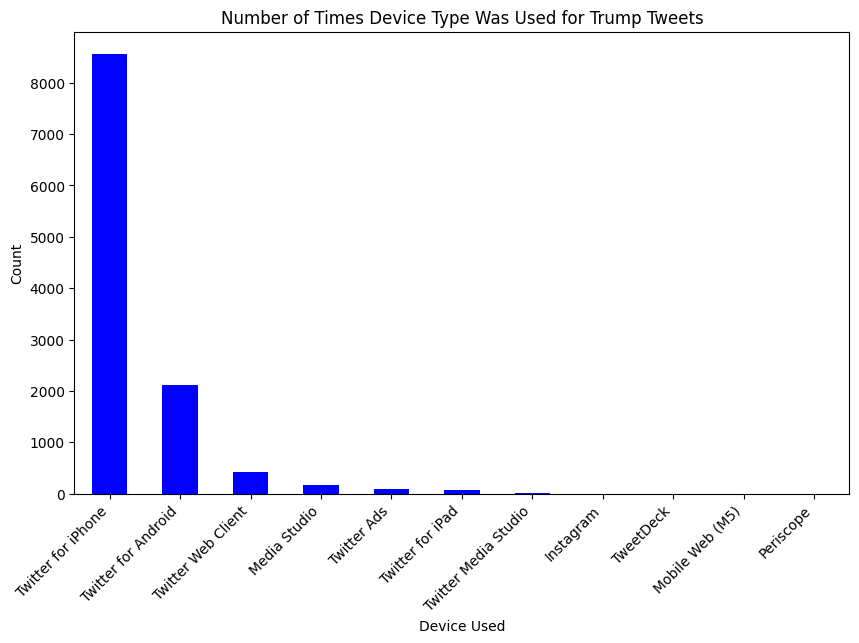

In [10]:
#get counts of each device usage in descending order
device_usages = df_trump['source'].value_counts()

#set figure size and create a bar plot
plt.figure(figsize=(10, 6))
device_usages.plot(kind='bar', color ='blue')

#set title, y and y label
plt.title('Number of Times Device Type Was Used for Trump Tweets')
plt.xlabel('Device Used')
plt.ylabel('Count')

#rotate x ticks 45 degrees so they don't overlap
plt.xticks(rotation=45, ha='right') 

#display bar plot
plt.show()

For further anaylsis, convert timestamps to be in EST time zone, to correspond to Trumps majority of tweets which occur in Washington during this time period. This will be done by creating a new 'est_time' column in the dataframe.

In [11]:
df_trump['est_time'] = (
    df_trump['time']
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
df_trump.head()

,time,source,text,retweet_count,favorite_count,est_time
id,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of m...",2108,6735,2015-12-31 19:44:14-05:00
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,3460,8581,2015-12-31 22:25:27-05:00
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143,2016-01-01 00:18:23-05:00
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,1948,8258,2016-01-01 01:07:28-05:00
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of...",2721,7490,2016-01-01 01:08:06-05:00


Create a new 'roundhour' column to store the approximate hour of the day for each tweet.

In [12]:
#apply formula to 'est_time' column to compute the 'hour' column values
df_trump['hour'] = (df_trump['est_time'].dt.hour) + (df_trump['est_time'].dt.minute/60) + (df_trump['est_time'].dt.second/3600)

# a new column that contains the rounded hour
df_trump['roundhour']=round(df_trump['hour'])

#display new 'hour' and 'roundhour' column 
df_trump.head()

,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour
id,,,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of m...",2108,6735,2015-12-31 19:44:14-05:00,19.737222,20.0
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,3460,8581,2015-12-31 22:25:27-05:00,22.424167,22.0
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143,2016-01-01 00:18:23-05:00,0.306389,0.0
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,1948,8258,2016-01-01 01:07:28-05:00,1.124444,1.0
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of...",2721,7490,2016-01-01 01:08:06-05:00,1.135000,1.0


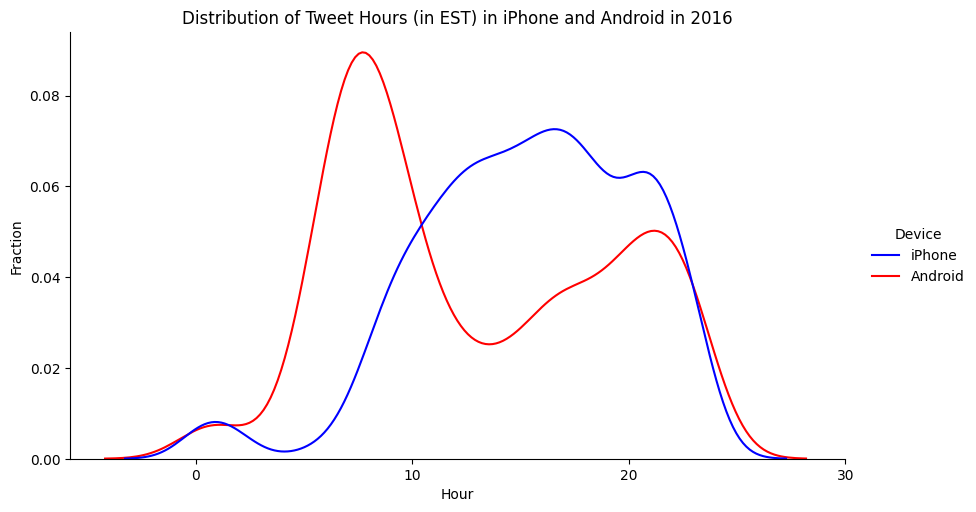

In [13]:
#using displot once again since distplot is deprecated... 

#filter df_trump to include only iPhone and Android tweets from 2016 ONLY and combine them into one df 'df_combined_devices' for plotting
df_combined_devices_2016 = pd.concat([
    df_trump[(df_trump['est_time'].dt.year == 2016) & (df_trump['source'] == 'Twitter for iPhone')].assign(Device='iPhone'),
    df_trump[(df_trump['est_time'].dt.year == 2016) & (df_trump['source'] == 'Twitter for Android')].assign(Device='Android')
])

#plot the distribution using sns.displot
sns.displot(data=df_combined_devices_2016, x='roundhour', hue='Device', kind='kde', common_norm=False, aspect=1.75, palette={'iPhone': 'blue', 'Android': 'red'})

#set title, x and y label
plt.title('Distribution of Tweet Hours (in EST) in iPhone and Android in 2016')
plt.xlabel('Hour')
plt.ylabel('Fraction')

#set x and y ticks manually to match those of the sample output above 
plt.xticks([0, 10, 20, 30])
plt.yticks([0.00, 0.02, 0.04, 0.06, 0.08])

#display plot
plt.show()

Create a wordcloud of most common words tweeted out by Trump... first create a function that remove's URLs from consideration in word frequency.

In [14]:
#use regex pattern to disregard https urls
def remove_urls(text):
    """Remove URLs from the given text."""
    return re.sub(r'http\S+|www\.\S+', '', text)

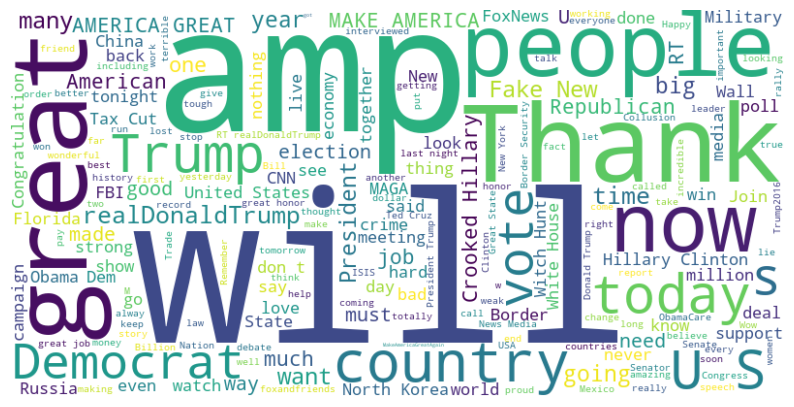

In [15]:
#combine all tweets into one string
all_text = " ".join(df_trump['text'])

#remove urls using the function
cleaned_text = remove_urls(all_text)

#generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis",
    max_words=200
).generate(cleaned_text)

#display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Extract the top 10 most common hashtagged terms used in Trump tweets

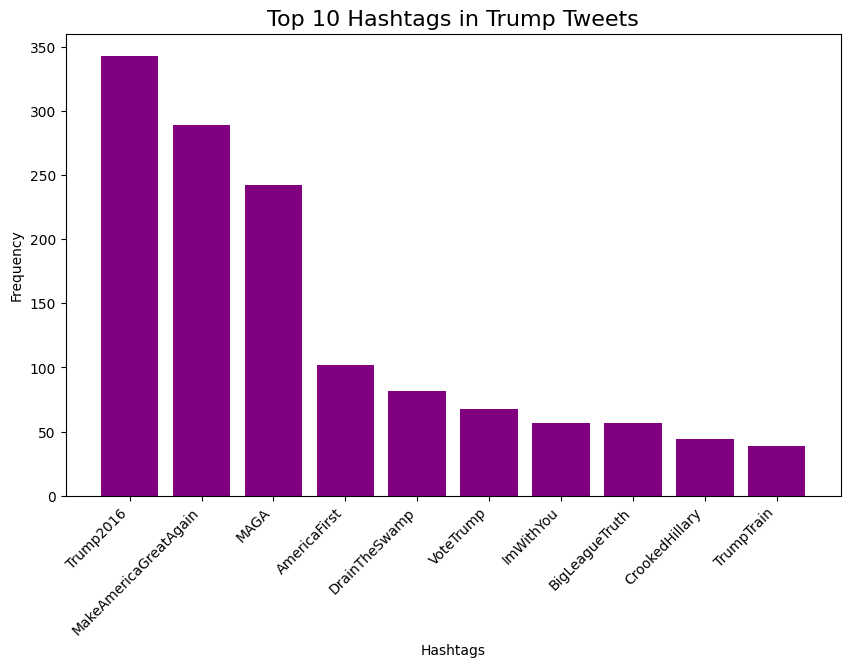

In [16]:
#create a new hashtags column by pattern matching with regex
df_trump['hashtags'] = df_trump['text'].apply(lambda x: re.findall(r"#(\w+)", x))

#flatten the list and count the frequencies
all_hashtags = [hashtag for hashtags in df_trump['hashtags'] for hashtag in hashtags]
hashtag_counts = Counter(all_hashtags)

#create a bar plot of top 10 hashtags
top_hashtags = hashtag_counts.most_common(10)
hashtags, counts = zip(*top_hashtags)

plt.figure(figsize=(10, 6))
plt.bar(hashtags, counts, color='purple')
plt.title('Top 10 Hashtags in Trump Tweets', fontsize=16)
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

Create a distribution of tweet length per Trump tweet in number of characters, get the statistics of each tweet length.

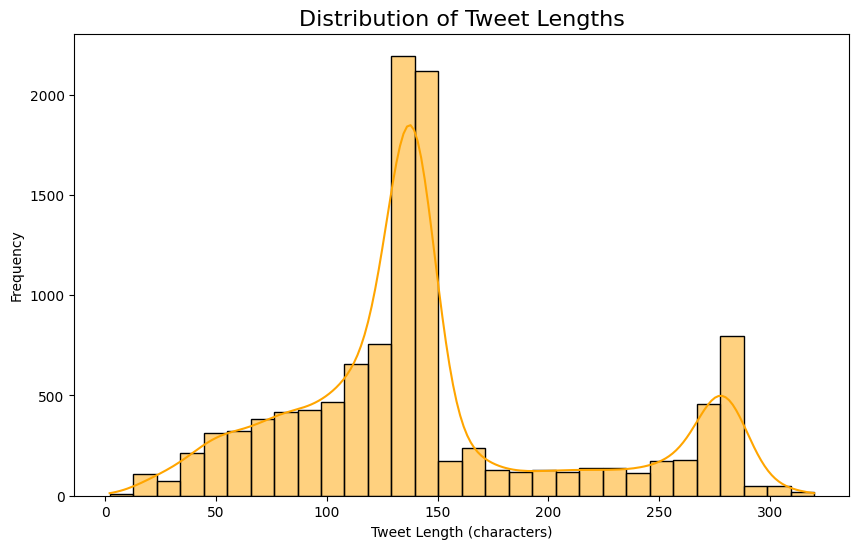

count    11479.000000
mean       146.953045
std         66.619381
min          2.000000
25%        110.000000
50%        138.000000
75%        159.000000
max        320.000000
Name: tweet_length, dtype: float64


In [17]:
#add a new column to get length of each tweet
df_trump['tweet_length'] = df_trump['text'].apply(len)

#plot tweet length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_trump['tweet_length'], bins=30, kde=True, color='orange')
plt.title('Distribution of Tweet Lengths', fontsize=16)
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.show()

#desplay summary statistics
print(df_trump['tweet_length'].describe())

### PART 2: Sentiment Analysis

Download the VADER lexicon

In [18]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sujayathrey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Clean each text tweet to include no punctuation, no uppercase letters, and no links. This will ensure the VADER lexicon correctly matches to the text and retrieves the correct valence scores.

In [19]:
#func to clean the text of each tweet
def clean_text(text):
    text = text.lower() #ensures lowercase
    text = re.sub(r'http\S+|www\S+', '', text) #removes links
    text = re.sub(r'[^\w\s]', '', text) #removes punctuation
    
    return text

#create new 'cleaned_text' col and apply the cleaning function to it
df_trump['cleaned_text'] = df_trump['text'].apply(clean_text)

Apply the VADER lexicon to classify each tweet as positive, neutral, or negative

In [20]:
#initialize sentiment anaylzer
sia = SentimentIntensityAnalyzer()

#func to classify each tweet with proper sentiment
def get_sentiment(text):
    """Classify text sentiment based on VADER polarity scores."""
    score = sia.polarity_scores(text)['compound'] #sums up the valence/polarity scores of each word in the tweet
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

#add a new 'sentiment' column to the dataframe to store the 3 classifications (+/neutral/-)
df_trump['sentiment'] = df_trump['cleaned_text'].apply(get_sentiment)
df_trump.head()

,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour,hashtags,tweet_length,cleaned_text,sentiment
id,,,,,,,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of m...",2108,6735,2015-12-31 19:44:14-05:00,19.737222,20.0,[],134,i will be on foxnews live with members of my ...,positive
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,3460,8581,2015-12-31 22:25:27-05:00,22.424167,22.0,[],79,happy new year amp thank you,positive
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143,2016-01-01 00:18:23-05:00,0.306389,0.0,[HappyNewYearAmerica],45,happynewyearamerica,neutral
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,1948,8258,2016-01-01 01:07:28-05:00,1.124444,1.0,[MarALago],109,happy new year from maralago thank you to my g...,positive
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of...",2721,7490,2016-01-01 01:08:06-05:00,1.135000,1.0,[],136,jallenaip hillary said she was in a fog of war...,negative


At this stage, the tweet text has been cleaned/normalized, and a sentiment label (positive/neutral/negative) has been added in the 'sentiment' column of the dataset.

Create a term-frequency matrix to convert the raw text of each tweet into its numerical representation. This allows each feature in the matrix to represent a word and its respective importance. The inverse-document-frequency (IDF) will penalize words that appear across many documents.

In [21]:
#init TF-IDF vectorizer

#will contain 5000 features (words) from the text tweets
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english') #includes 'at', 'and', 'it', etc...

#fit/transform the text tweets from 'cleaned_text' col created earlier
X = vectorizer.fit_transform(df_trump['cleaned_text'])

To visualize how the TF-IDF matrix (X) looks, convert to a dataframe and display the head

In [22]:
#convert to pandas df
tf_idf_matrix_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

#display matrix
tf_idf_matrix_df.head()

,10,100,1000,10000,100000,100th,10pm,10pme,11,1100,...,youth,youtube,youve,yrs,yuma,zero,zone,zones,zte,zuckerman
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Once the text has been numerically represented in the tf-idf matrix, convert the 3 sentiment labels to numerical labels (1, 2, 3) respectively, using a label encoder.

In [23]:
#init label encoder
label_encoder = LabelEncoder()

#convert 'sentiment' col to numerical labels
y = label_encoder.fit_transform(df_trump['sentiment'])

#check the labels 
y[:10]

array([2, 2, 1, 2, 0, 2, 2, 2, 2, 2])

Split the tf-idf matrix into training and testing datasets, with 80% for training and 20% testing.

In [24]:
#split into training/testing with 80/20 split, set random seed num to 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

#display shape of training/testing dataset
X_train.shape, X_test.shape

((9183, 5000), (2296, 5000))

Now that the data preprocessing and vectorization into numerical features/label encoding has been completed, fit ML models on the training data created and test on the testing data created...

### LOGISTIC REGRESSION MODEL: 

In [25]:
#initialize logistic regression model
log_regression_model = LogisticRegression(max_iter=2500)

#train model on training data
log_regression_model.fit(X_train, y_train)

#predict model on testing data
y_pred = log_regression_model.predict(X_test)

Display Logistic Regression Model performance metrics... accuracy, as well as recall, precision, f-score, support...

In [26]:
#eval logistic regression model
print(f'Accuracy:, {accuracy_score(y_test, y_pred)}')
print(f'Classification Report: {classification_report(y_test, y_pred, target_names=label_encoder.classes_)}')

Accuracy:, 0.8000871080139372
Classification Report:               precision    recall  f1-score   support

    negative       0.78      0.76      0.77       673
     neutral       0.79      0.43      0.56       350
    positive       0.81      0.92      0.86      1273

    accuracy                           0.80      2296
   macro avg       0.79      0.70      0.73      2296
weighted avg       0.80      0.80      0.79      2296



### RANDOM FOREST MODEL:

In [27]:
#initialize rand forest model
rf_model = RandomForestClassifier(n_estimators=100) #100 trees (estimators)

#train model on training data
rf_model.fit(X_train, y_train)

#predict model on testing data
y_pred_rf = rf_model.predict(X_test)

Display Random Forest Model performance metrics... accuracy, as well as recall, precision, f-score, support...

In [28]:
#eval logistic regression model
print(f'Accuracy:, {accuracy_score(y_test, y_pred_rf)}')
print(f'Classification Report: {classification_report(y_test, y_pred_rf)}')

Accuracy:, 0.7996515679442509
Classification Report:               precision    recall  f1-score   support

           0       0.76      0.73      0.74       673
           1       0.68      0.65      0.67       350
           2       0.85      0.88      0.86      1273

    accuracy                           0.80      2296
   macro avg       0.76      0.75      0.76      2296
weighted avg       0.80      0.80      0.80      2296



### Support Vector Machine (SVM) MODEL:

In [29]:
#initialize SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can also try 'rbf' kernel for non-linear data

#train model on training data
svm_model.fit(X_train, y_train)

#test model on testing data
y_pred_svm = svm_model.predict(X_test)

Display SVM Model performance metrics... accuracy, as well as recall, precision, f-score, support...

In [30]:
#eval logistic regression model
print(f'Accuracy:, {accuracy_score(y_test, y_pred_svm)}')
print(f'Classification Report: {classification_report(y_test, y_pred_svm)}')

Accuracy:, 0.8166376306620209
Classification Report:               precision    recall  f1-score   support

           0       0.76      0.78      0.77       673
           1       0.76      0.59      0.67       350
           2       0.86      0.89      0.88      1273

    accuracy                           0.82      2296
   macro avg       0.79      0.76      0.77      2296
weighted avg       0.81      0.82      0.81      2296



To visualize the performance of the three models, generate a confusion matrix of each model to determine visually how well each model classifies the three sentiment labels (positive, neutral, negative) when looking at actual vs predicted sentiment labels

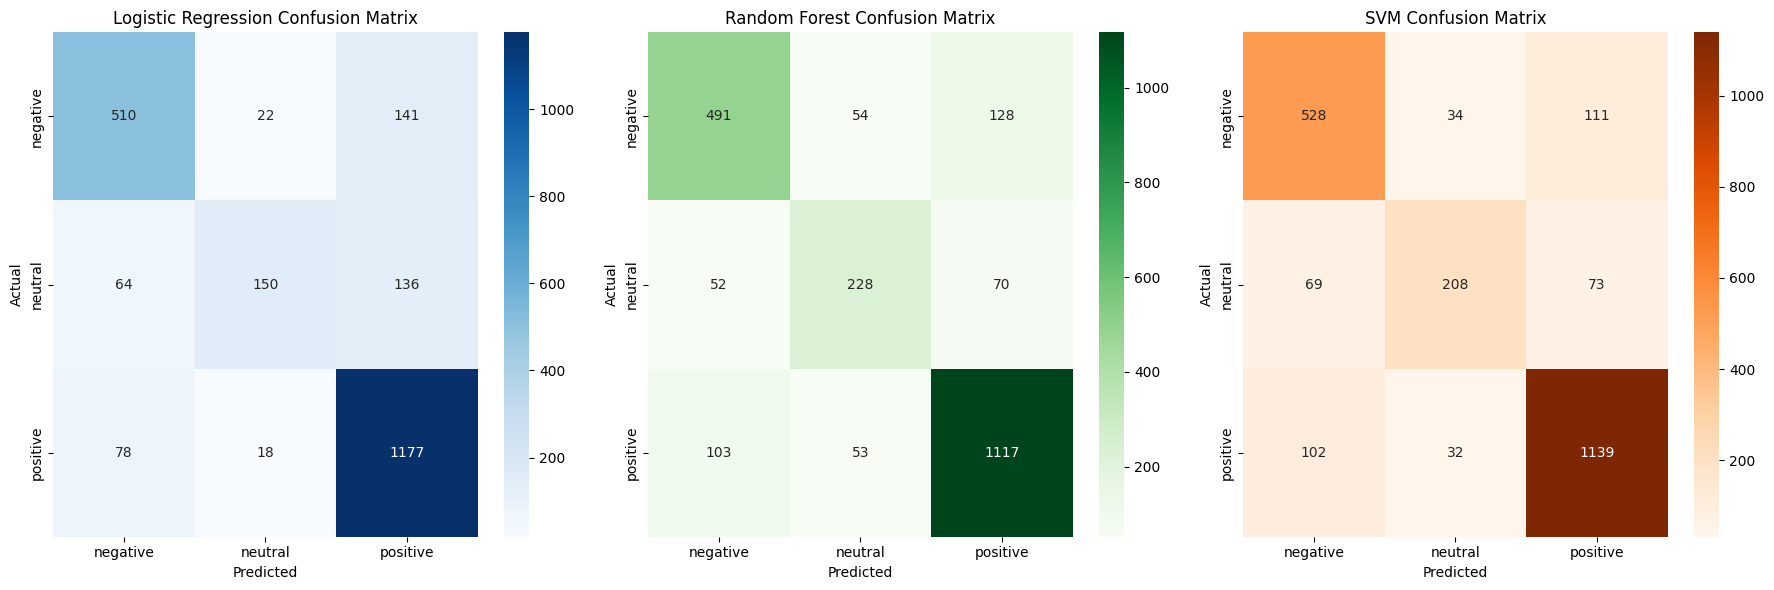

In [31]:
#generate confusion matrices for each model
cm_log_reg = confusion_matrix(y_test, log_regression_model.predict(X_test))
cm_rf = confusion_matrix(y_test, rf_model.predict(X_test))
cm_svm = confusion_matrix(y_test, svm_model.predict(X_test))

#plot each confusion matrix
plt.figure(figsize=(18, 6))

#Logistic Regression Model confusion matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#Random Forest Model confusion matrix
plt.subplot(1, 3, 2)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#SVM Model confusion matrix
plt.subplot(1, 3, 3)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()